## Jon Stingel
#### this notebook is for importing metabolic data and train/testing simple regression models on

In [1]:
import os
import pandas as pd
import glob
import math
import numpy as np
import matplotlib.pyplot as plt
# import h5py
import scipy

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns

# pd.set_option('display.max_rows',None,'display.max_columns',None)

In [2]:
## import the experimental values
# set paths
repobasedir = os.getcwd()
experimentalfile = os.path.join(repobasedir, 'experimentalMetabolics_all.csv')
# read in the file to dataframe
expmetcost_df = pd.read_csv(experimentalfile)
# print(expmetcost_df)

In [3]:
## import all of the simulation results
# set all the paths
simresultspath = os.path.join(repobasedir,'..\\metabolicsResults\\')
muscleInversepath = os.path.join(simresultspath,'muscleInverse\\')
muscleInverseWithEMGpath = os.path.join(simresultspath,'muscleInverseWithEMG\\')

## first handle the values in the regular muscle driven inverse problem
# get all the filenames
musclefiles = glob.glob(os.path.join(muscleInversepath,'*.csv'))
# load them all into a single dataframe
df_from_each_file = (pd.read_csv(f) for f in musclefiles)
# print(df_from_each_file)
muscle_df = pd.concat(df_from_each_file, ignore_index=True)
# print(muscle_df)

In [4]:
# manipulate and get a dataframe with all the values you are testing
test_df = muscle_df.groupby(['subjectname','condname','trialname']).agg({'metabolics_all_avg':['mean']})
test_df.columns = ['metabolics_all_avg_mean']
test_df = test_df.reset_index()
# print(test_df)

exp_df = expmetcost_df.groupby(['subjectname','condname','trialname']).agg({'metabolics_all_avg':['mean']})
exp_df.columns = ['metabolics_all_avg_mean']
exp_df = exp_df.reset_index()
# print(exp_df)


both_df = pd.merge(test_df, exp_df, how='right', on=['subjectname','condname','trialname'])
pd.set_option('display.max_rows',None) #,'display.max_columns',None)

bothtrim_df = both_df.dropna()
print(bothtrim_df)

   subjectname        condname trialname  metabolics_all_avg_mean_x  \
0      demb005  dembloadedfree   trial01                   6.351613   
1      demb005  dembloadedfree   trial03                   5.739812   
2      demb005  dembloadedfree   trial06                   6.478808   
6      demb005  dembnoloadfree   trial02                   4.902574   
7      demb005  dembnoloadfree   trial03                   5.150562   
8      demb005  dembnoloadfree   trial06                   4.930209   
12     demb007  dembloadedfree   trial01                   6.090161   
13     demb007  dembloadedfree   trial02                   6.031778   
14     demb007  dembloadedfree   trial05                   6.304887   
18     demb007  dembnoloadfree   trial01                   4.461623   
19     demb007  dembnoloadfree   trial02                   4.779362   
20     demb007  dembnoloadfree   trial03                   4.753765   
24     demb009  dembloadedfree   trial04                   6.109172   
25    

In [5]:
############################################################################
# linear regression model
X = bothtrim_df['metabolics_all_avg_mean_x'].values.reshape(-1,1)
# print('x')
# print(X)
Y = bothtrim_df['metabolics_all_avg_mean_y'].values.reshape(-1,1)
# print('y')
# print(Y)

reg = LinearRegression()
reg.fit(X,Y)

print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))
predictions = reg.predict(X)

# baseline error
mse_baseline = mean_squared_error(Y,X)
rmse_baseline = np.sqrt(mse_baseline)
print('\nRMSE baseline: %f W/kg' % rmse_baseline)



The linear model is: Y = 0.2625 + 1.0564X

RMSE baseline: 1.065300 W/kg


c:\users\jp\.conda\envs\pymoco\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\users\jp\.conda\envs\pymoco\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


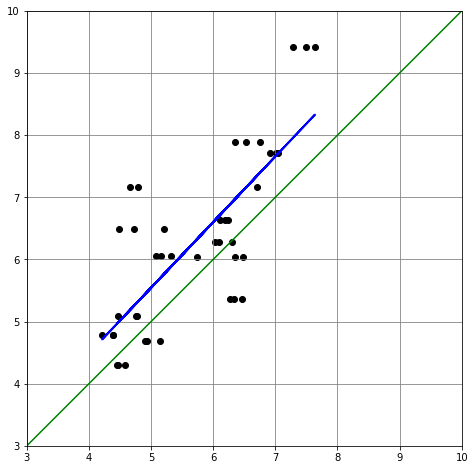

In [6]:
# plotting the linear regression model
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

plt.scatter(bothtrim_df['metabolics_all_avg_mean_x'],
    bothtrim_df['metabolics_all_avg_mean_y'],
    c='black')
plt.plot(bothtrim_df['metabolics_all_avg_mean_x'],
    predictions,
    c='blue',
    linewidth=2)
plt.grid(color='grey')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-')

ax.set_aspect('equal')
plt.xlim((3,10))
plt.ylim((3,10))
plt.show()

In [14]:
#######################################################
## single decision tree implementation
X_dt = bothtrim_df.metabolics_all_avg_mean_x.values.reshape(-1,1)
Y_dt = bothtrim_df.metabolics_all_avg_mean_y.values.reshape(-1,1)

# x_train_dt, x_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt,Y_dt,test_size=0.15,random_state=12)
x_train_dt = X_dt[0:30,:]
temp = X_dt[36:-1,:]
x_train_dt = np.append(x_train_dt, temp, axis=0)
y_train_dt = Y_dt[0:30,:]
temp2 = Y_dt[36:-1,:]
y_train_dt = np.append(y_train_dt, temp2, axis=0)
x_test_dt = X_dt[30:36,:]
y_test_dt = Y_dt[30:36,:]

print(x_train_dt.shape)
print(y_train_dt.shape)
print(x_test_dt.shape)
print(y_test_dt.shape)

# x_train = x_train.reshape(-1,)
y_train_dt = y_train_dt.reshape(-1,)
# x_test_dt = x_test_dt.reshape(-1,)
y_test_dt = y_test_dt.reshape(-1,)
# print(x_train_dt.shape)
# print(y_train_dt.shape)

DecisionTreeRegModel = DecisionTreeRegressor(random_state=13, criterion='mse')
DecisionTreeRegModel.fit(x_train_dt, y_train_dt)



(35, 1)
(35, 1)
(6, 1)
(6, 1)


DecisionTreeRegressor(random_state=13)

y_test_dt:
[7.708152 7.708152 7.708152 6.061044 6.061044 6.061044]
y_pred_dt:
[9.421522 7.890412 7.890412 4.682754 6.489858 4.682754]

RMSE: 1.078990


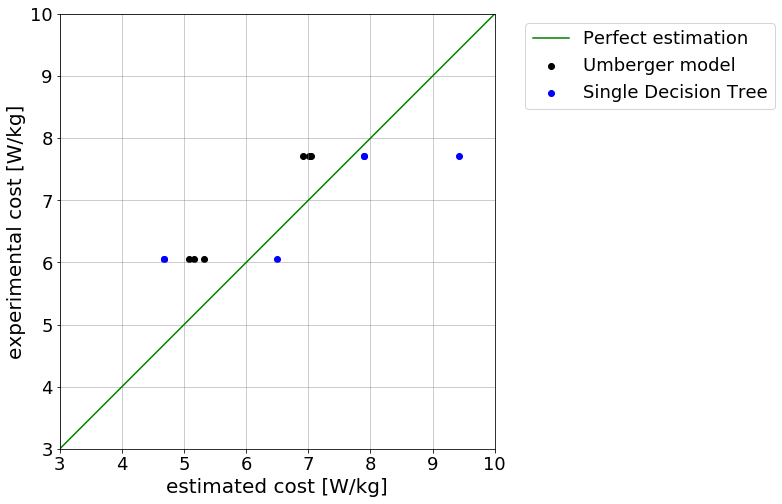

In [15]:
# try some predictions
print('y_test_dt:')
print(y_test_dt)
y_pred_dt = DecisionTreeRegModel.predict(x_test_dt)
print('y_pred_dt:')
print(y_pred_dt)

# error
mse_dt = mean_squared_error(y_test_dt, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
print('\nRMSE: %f' % rmse_dt)

# plot the random forest 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

plt.scatter(x_test_dt,y_test_dt,
    c='black', label='Umberger model')
plt.scatter(y_pred_dt, y_test_dt,
    c='blue', label='Single Decision Tree')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

In [24]:
########################################################
## random forest implementation

X_rf = bothtrim_df.metabolics_all_avg_mean_x.values.reshape(-1,1)
Y_rf = bothtrim_df.metabolics_all_avg_mean_y.values.reshape(-1,1)

# x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf,Y_rf,test_size=0.15,random_state=12)
x_train_rf = X_rf[0:30,:]
temp = X_rf[36:-1,:]
x_train_rf = np.append(x_train_rf, temp, axis=0)
y_train_rf = Y_rf[0:30,:]
temp2 = Y_rf[36:-1,:]
y_train_rf = np.append(y_train_rf, temp2, axis=0)
x_test_rf = X_rf[30:36,:]
y_test_rf = Y_rf[30:36,:]




# x_train_rf = x_train_rf.reshape(-1,)
y_train_rf = y_train_rf.reshape(-1,)
# x_test_rf = x_test_rf.reshape(-1,)
y_test_rf = y_test_rf.reshape(-1,)
# print(x_train_rf.shape)
# print(y_train_rf.shape)

RandomForestRegModel = RandomForestRegressor(random_state=13, n_estimators=50)
RandomForestRegModel.fit(x_train_rf, y_train_rf)



RandomForestRegressor(n_estimators=50, random_state=13)

y_test_rf:
[7.708152 7.708152 7.708152 6.061044 6.061044 6.061044]
y_pred_rf:
[8.85585294 8.18216454 7.95670624 5.16086922 5.93873542 5.16086922]

RMSE: 0.734764


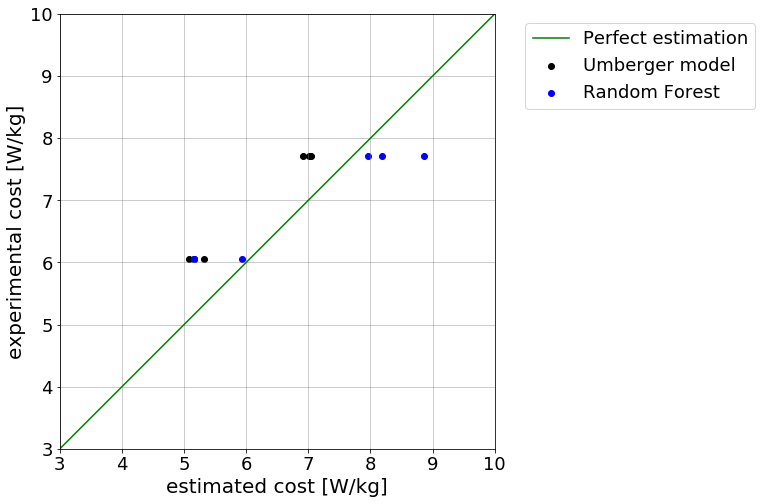

In [25]:
# try some predictions
print('y_test_rf:')
print(y_test_rf)
y_pred_rf = RandomForestRegModel.predict(x_test_rf)
print('y_pred_rf:')
print(y_pred_rf)

# error
mse_rf = mean_squared_error(y_test_rf, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print('\nRMSE: %f' % rmse_rf)

# plot the random forest 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

plt.scatter(x_test_rf,y_test_rf,
    c='black', label='Umberger model')
plt.scatter(y_pred_rf, y_test_rf,
    c='blue', label='Random Forest')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

# Getting X  values with all the umberger components

In [26]:
## import all of the simulation results
# set all the paths
simresultspath = os.path.join(repobasedir,'..\\metabolicsResults\\')
muscleInversepath = os.path.join(simresultspath,'muscleInverse\\')
muscleInverseWithEMGpath = os.path.join(simresultspath,'muscleInverseWithEMG\\')

## first handle the values in the regular muscle driven inverse problem
# get all the filenames
musclefiles = glob.glob(os.path.join(muscleInversepath,'*.csv'))
# load them all into a single dataframe
df_from_each_file = (pd.read_csv(f) for f in musclefiles)
# print(df_from_each_file)
muscle_df = pd.concat(df_from_each_file, ignore_index=True)
muscle_df.sort_values(by=['subjectname','condname','trialname'],inplace=True)
muscle_df.drop(['Row'],inplace=True,axis=1)
muscle_df.reset_index(inplace=True,drop=True)
# print(muscle_df)

In [27]:
# figure out how to pair down the experimental to only have these ones
combos = []
for index, row in muscle_df.iterrows():
    subj = row['subjectname']
    cond = row['condname']
    trial = row['trialname']
    combos.append((subj,cond,trial))
combosunique = set(combos)
# print(combosunique)

idk = pd.merge(expmetcost_df, muscle_df, how='left', indicator=True)
idk2 = idk.reset_index()

indextodrop = []
for index, row in idk2.iterrows():
    subj = row['subjectname']
    cond = row['condname']
    trial = row['trialname']
    if (subj,cond,trial) not in combosunique:
        indextodrop.append(index)

idk3 = idk2.drop(indextodrop)
# print(idk3)
idk4 = idk3.drop(['index','_merge','metabolics_mech_avg','metabolics_basal_avg','metabolics_short_avg','metabolics_act_avg'], axis=1)
# print(idk4)
# sort the dataframe TODO sort the sims one the same way
idk5 = idk4.sort_values(by=['subjectname','condname','trialname'])
idk5.reset_index(inplace=True,drop=True)

exp_df = idk5
# print(exp_df)


## random forest for all umberger inputs

In [41]:
# set up the X and Y
X_multi_rf = muscle_df.iloc[:,0:5].values
# print(X_multi_rf)
Y_multi_rf = exp_df.iloc[:,0].values
# print(Y_multi_rf)

# split into sets
# x_train_multi_rf,x_test_multi_rf,y_train_multi_rf,y_test_multi_rf = train_test_split(X_multi_rf,Y_multi_rf,
#                                                                                      test_size=0.15,
#                                                                                     random_state=12)
x_train_multi_rf = X_multi_rf[0:30,:]
temp = X_multi_rf[36:-1,:]
x_train_multi_rf = np.append(x_train_multi_rf, temp, axis=0)
y_train_multi_rf = Y_multi_rf[0:30]
temp2 = Y_multi_rf[36:-1]
y_train_multi_rf = np.append(y_train_multi_rf, temp2, axis=0)
x_test_multi_rf = X_multi_rf[30:36,:]
y_test_multi_rf = Y_multi_rf[30:36]




# print(X_multi_rf.shape)
# print(Y_multi_rf.shape)

print(x_train_multi_rf.shape)
print(y_train_multi_rf.shape)
print(x_test_multi_rf.shape)
print(y_test_multi_rf.shape)

multiregrf = RandomForestRegressor(n_estimators=1000, random_state=13)
multiregrf.fit(x_train_multi_rf,y_train_multi_rf)
y_pred_multi_rf = multiregrf.predict(x_test_multi_rf)
y_pred_multi_rf_train = multiregrf.predict(x_train_multi_rf)


(35, 5)
(35,)
(6, 5)
(6,)


y_test_multi_rf:
[7.708152 7.708152 7.708152 6.061044 6.061044 6.061044]
y_pred_rf:
[8.98942822 8.47536609 8.33589299 6.18180249 6.29054407 6.23607903]

RMSE baseline: 1.065300

RMSE training: 0.245720

RMSE test: 0.673577


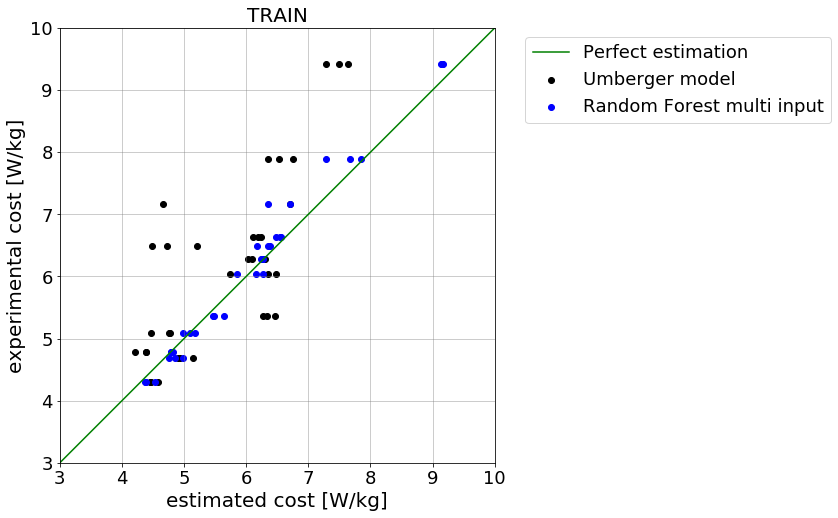

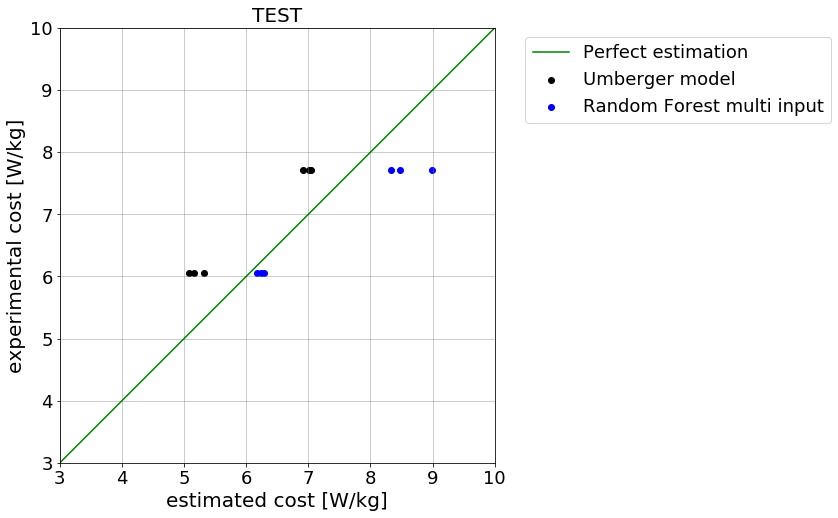

In [42]:
# try some predictions
print('y_test_multi_rf:')
print(y_test_multi_rf)
print('y_pred_rf:')
print(y_pred_multi_rf)

# error
mse_multi_rf_base = mean_squared_error(Y_multi_rf,X_multi_rf[:,0])
rmse_multi_rf_base = np.sqrt(mse_multi_rf_base)
print('\nRMSE baseline: %f' % rmse_multi_rf_base)

mse_multi_rf_train = mean_squared_error(y_train_multi_rf, y_pred_multi_rf_train)
rmse_multi_rf_train = np.sqrt(mse_multi_rf_train)
print('\nRMSE training: %f' % rmse_multi_rf_train)

mse_multi_rf = mean_squared_error(y_test_multi_rf, y_pred_multi_rf)
rmse_multi_rf = np.sqrt(mse_multi_rf)
print('\nRMSE test: %f' % rmse_multi_rf)

# plot the random forest
fig1 = plt.figure(figsize=(8,8))
ax = fig1.add_subplot(111)

plt.scatter(x_train_multi_rf[:,0],y_train_multi_rf,
    c='black', label='Umberger model')
plt.scatter(y_pred_multi_rf_train, y_train_multi_rf,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TRAIN',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)



fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111)

plt.scatter(x_test_multi_rf[:,0],y_test_multi_rf,
    c='black', label='Umberger model')
plt.scatter(y_pred_multi_rf, y_test_multi_rf,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TEST',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

In [43]:
# get importance of features
importance = list(multiregrf.feature_importances_)
print(importance)

featurelist = list(muscle_df.columns)
# featurelist.remove(['subjectname','condname','experimentname','trialname'])
featurelist.remove('subjectname')
featurelist.remove('condname')
featurelist.remove('experimentname')
featurelist.remove('trialname')

# list of tubles with variable and importance
feature_importances = [(feature, round(importance,2)) for feature, importance in zip(featurelist,importance)]

# sort the feature importances bu most important 
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

[0.22444593445159142, 0.12559519892549176, 0.035040283796192576, 0.5505998419771558, 0.06431874084956836]
Variable: metabolics_basal_avg Importance: 0.55
Variable: metabolics_all_avg   Importance: 0.22
Variable: metabolics_act_avg   Importance: 0.13
Variable: metabolics_mech_avg  Importance: 0.06
Variable: metabolics_short_avg Importance: 0.04


[None, None, None, None, None]

## try deep learning model

In [31]:
# set up the X and Y
X_multi_nn = muscle_df.iloc[:,0:5].values
# print(X_multi_nn)
Y_multi_nn = exp_df.iloc[:,0].values.reshape(-1,1)
# print(Y_multi_nn.shape)

# split into sets
# x_train_multi_nn,x_test_multi_nn,y_train_multi_nn,y_test_multi_nn = train_test_split(X_multi_nn,Y_multi_nn,
#                                                                                      test_size=0.15,
#                                                                                     random_state=12)
x_train_multi_nn = X_multi_nn[0:30,:]
temp = X_multi_nn[36:-1,:]
x_train_multi_nn = np.append(x_train_multi_nn, temp, axis=0)
y_train_multi_nn = Y_multi_nn[0:30]
temp2 = Y_multi_nn[36:-1]
y_train_multi_nn = np.append(y_train_multi_nn, temp2, axis=0)
x_test_multi_nn = X_multi_nn[30:36,:]
y_test_multi_nn = Y_multi_nn[30:36]

# reshape
x_train_multi_nn.reshape



# print(X_multi_nn.shape)
# print(Y_multi_nn.shape)

print(x_train_multi_nn.shape)
print(y_train_multi_nn.shape)
print(x_test_multi_nn.shape)
print(y_test_multi_nn.shape)


(35, 5)
(35, 1)
(6, 5)
(6, 1)


In [32]:
# model create and train
import numpy as np
from keras import layers
from keras.layers import Input, Dense #, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
# from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



# from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
# from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
# from kt_utils import *

import keras.backend as K
# K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

Using TensorFlow backend.


In [33]:
# create the base model
def baseline_model(input_shape):
    
#     # create the model
#     model = Sequential()
#     model.add(Dense(5, input_dim=5, kernel_initializer='normal', activation='relu'))
#     model.add(Dense(4, kernel_initializer='normal'))
#     model.add(Dense(2, kernel_initializer='normal'))
#     model.add(Dense(1, kernel_initializer='normal'))
#     # compile model
#     model.compile(loss='mean_squared_error', optimizer='adam')
    
    X_input = Input(input_shape)
    
    X = Dense(5, input_dim=input_shape, kernel_initializer='normal', activation='relu')(X_input)
    X = Dense(5, activation='relu', kernel_initializer='normal')(X)
    X = Dense(4, activation='relu', kernel_initializer='normal')(X)
    X = Dense(3, activation='relu', kernel_initializer='normal')(X)
    X = Dense(1, kernel_initializer='normal', activation='linear')(X)
    
    model = Model(inputs=X_input, outputs=X, name='baselineModel')
    
    
    return model

In [34]:
# evaluate model
# estimator = KerasRegressor(build_fn=baseline_model, epochs=1000, verbose=0)
# kfold = KFold(n_splits=7)
# results = cross_val_score(estimator, x_train_multi_nn, y_train_multi_nn, cv=kfold)
# results = cross_val_score(estimator, X_multi_nn, Y_multi_nn, cv=kfold)

# print('Baseline: %.2f (%.2f) MSE' % (results.mean(), results.std()))
x_train_multi_nn.shape[1:]

(5,)

In [35]:
# create the model
basemodel = baseline_model(x_train_multi_nn.shape[1:])

In [36]:
basemodel.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mean_squared_error'])

In [37]:
basemodel.fit(x=x_train_multi_nn, y=y_train_multi_nn, epochs=300)


Epoch 1/300
35/35 [==============================] - 0s 12ms/step - loss: 39.8757 - mean_squared_error: 39.8757
Epoch 2/300
35/35 [==============================] - 0s 169us/step - loss: 39.8539 - mean_squared_error: 39.8539
Epoch 3/300
35/35 [==============================] - 0s 124us/step - loss: 39.8290 - mean_squared_error: 39.8290
Epoch 4/300
35/35 [==============================] - 0s 142us/step - loss: 39.8041 - mean_squared_error: 39.8041
Epoch 5/300
35/35 [==============================] - 0s 157us/step - loss: 39.7788 - mean_squared_error: 39.7788
Epoch 6/300
35/35 [==============================] - 0s 165us/step - loss: 39.7536 - mean_squared_error: 39.7536
Epoch 7/300
35/35 [==============================] - 0s 129us/step - loss: 39.7285 - mean_squared_error: 39.7285
Epoch 8/300
35/35 [==============================] - 0s 171us/step - loss: 39.7029 - mean_squared_error: 39.7029
Epoch 9/300
35/35 [==============================] - 0s 114us/step - loss: 39.6777 - mean_square

35/35 [==============================] - 0s 114us/step - loss: 37.0743 - mean_squared_error: 37.0743
Epoch 72/300
35/35 [==============================] - 0s 148us/step - loss: 36.9834 - mean_squared_error: 36.9834
Epoch 73/300
35/35 [==============================] - 0s 116us/step - loss: 36.8891 - mean_squared_error: 36.8891
Epoch 74/300
35/35 [==============================] - 0s 94us/step - loss: 36.7914 - mean_squared_error: 36.7914
Epoch 75/300
35/35 [==============================] - 0s 122us/step - loss: 36.6884 - mean_squared_error: 36.6884
Epoch 76/300
35/35 [==============================] - 0s 114us/step - loss: 36.5819 - mean_squared_error: 36.5819
Epoch 77/300
35/35 [==============================] - 0s 104us/step - loss: 36.4691 - mean_squared_error: 36.4691
Epoch 78/300
35/35 [==============================] - 0s 147us/step - loss: 36.3519 - mean_squared_error: 36.3519
Epoch 79/300
35/35 [==============================] - 0s 114us/step - loss: 36.2281 - mean_squared_err

35/35 [==============================] - 0s 128us/step - loss: 9.6340 - mean_squared_error: 9.6340
Epoch 143/300
35/35 [==============================] - 0s 143us/step - loss: 9.0178 - mean_squared_error: 9.0178
Epoch 144/300
35/35 [==============================] - 0s 140us/step - loss: 8.4206 - mean_squared_error: 8.4206
Epoch 145/300
35/35 [==============================] - 0s 117us/step - loss: 7.8457 - mean_squared_error: 7.8457
Epoch 146/300
35/35 [==============================] - 0s 113us/step - loss: 7.2850 - mean_squared_error: 7.2850
Epoch 147/300
35/35 [==============================] - 0s 140us/step - loss: 6.7544 - mean_squared_error: 6.7544
Epoch 148/300
35/35 [==============================] - 0s 142us/step - loss: 6.2177 - mean_squared_error: 6.2177
Epoch 149/300
35/35 [==============================] - 0s 114us/step - loss: 5.7358 - mean_squared_error: 5.7358
Epoch 150/300
35/35 [==============================] - 0s 137us/step - loss: 5.2309 - mean_squared_error: 5.23

35/35 [==============================] - 0s 85us/step - loss: 0.9986 - mean_squared_error: 0.9986
Epoch 214/300
35/35 [==============================] - 0s 86us/step - loss: 0.9998 - mean_squared_error: 0.9998
Epoch 215/300
35/35 [==============================] - 0s 104us/step - loss: 1.0022 - mean_squared_error: 1.0022
Epoch 216/300
35/35 [==============================] - 0s 88us/step - loss: 1.0026 - mean_squared_error: 1.0026
Epoch 217/300
35/35 [==============================] - 0s 85us/step - loss: 1.0023 - mean_squared_error: 1.0023
Epoch 218/300
35/35 [==============================] - 0s 114us/step - loss: 1.0018 - mean_squared_error: 1.0018
Epoch 219/300
35/35 [==============================] - 0s 112us/step - loss: 1.0018 - mean_squared_error: 1.0018
Epoch 220/300
35/35 [==============================] - 0s 141us/step - loss: 1.0022 - mean_squared_error: 1.0022
Epoch 221/300
35/35 [==============================] - 0s 114us/step - loss: 1.0025 - mean_squared_error: 1.0025
E

35/35 [==============================] - 0s 86us/step - loss: 0.9843 - mean_squared_error: 0.9843
Epoch 286/300
35/35 [==============================] - 0s 114us/step - loss: 0.9863 - mean_squared_error: 0.9863
Epoch 287/300
35/35 [==============================] - 0s 142us/step - loss: 0.9889 - mean_squared_error: 0.9889
Epoch 288/300
35/35 [==============================] - 0s 112us/step - loss: 0.9904 - mean_squared_error: 0.9904
Epoch 289/300
35/35 [==============================] - 0s 112us/step - loss: 0.9917 - mean_squared_error: 0.9917
Epoch 290/300
35/35 [==============================] - 0s 119us/step - loss: 0.9910 - mean_squared_error: 0.9910
Epoch 291/300
35/35 [==============================] - 0s 137us/step - loss: 0.9879 - mean_squared_error: 0.9879
Epoch 292/300
35/35 [==============================] - 0s 145us/step - loss: 0.9849 - mean_squared_error: 0.9849
Epoch 293/300
35/35 [==============================] - 0s 116us/step - loss: 0.9841 - mean_squared_error: 0.984

In [38]:
preds = basemodel.evaluate(x=x_test_multi_nn, y=y_test_multi_nn)
print()
print('Loss = ' + str(preds[0]))
print('test MSE = ' + str(preds[1]))

6/6 [==============================] - 0s 10ms/step

Loss = 0.29963505268096924
test MSE = 0.29963505268096924


In [39]:
y_pred_train_multi_nn = basemodel.predict(x=x_train_multi_nn)
y_pred_test_multi_nn = basemodel.predict(x=x_test_multi_nn)

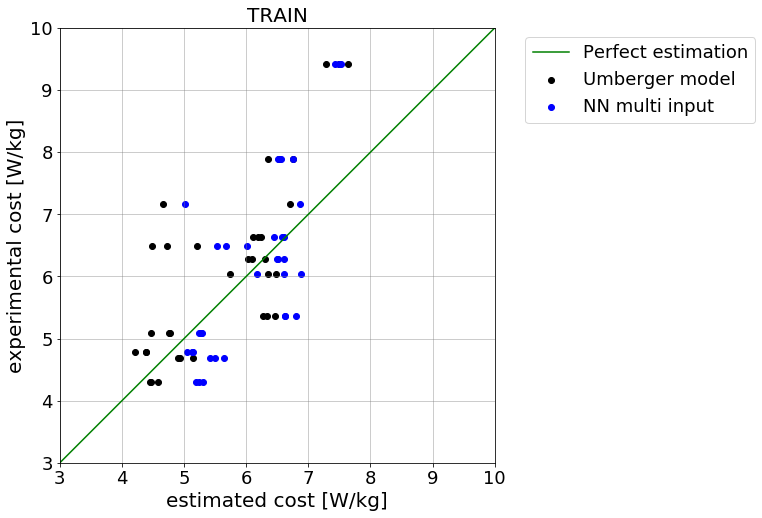

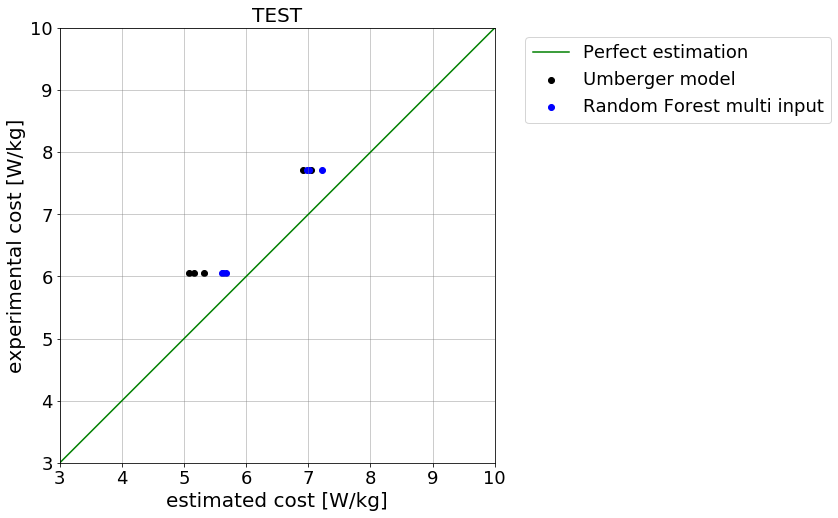

In [40]:
# try some predictions

# plot the random forest
fig1 = plt.figure(figsize=(8,8))
ax = fig1.add_subplot(111)

plt.scatter(x_train_multi_nn[:,0],y_train_multi_nn,
    c='black', label='Umberger model')
plt.scatter(y_pred_train_multi_nn, y_train_multi_nn,
    c='blue', label='NN multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TRAIN',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)



fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111)

plt.scatter(x_test_multi_nn[:,0],y_test_multi_nn,
    c='black', label='Umberger model')
plt.scatter(y_pred_test_multi_nn, y_test_multi_nn,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TEST',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()